# Assignment 1:  Superpixels and Image Segmentation.

Name: **Sai Surya Sriramoju**

UID:  **119224113**

Link to Google Drive : **View-only Link to Notebook Here (make sure it works)**

Please submit a PDF containing all outputs to gradescope by **October 5, 11:59pm**

----------------------------

In this assignment, you will learn about superpixels. You will first generate superpixels by clustering pixels via k-means. This will generate a superpixel map such as the following:

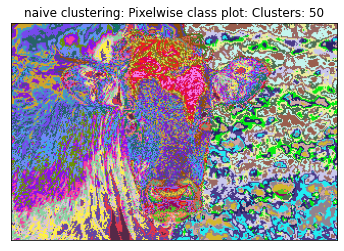

You will then implement a better superpixel algorithm: SLIC, which lets you generate superpixel maps like the following:

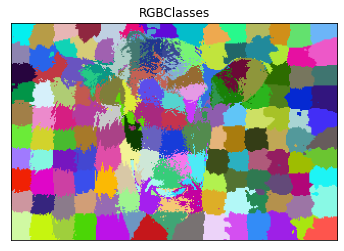

You will then build a segmentation network by training a deep neural network on your superpixels. This part is fairly open-ended, feel free to try any model you can think of (GNN, CNN, Transformer, etc.).

To give an example, for a CNN-based system that reformulates segmentation as superpixel image classification, there are basically three steps in the training stage:

1. Dilate and save each superpixel region from SLIC output into image of size 224X224, alongwith the ground truth segments label.
2. Build a couple of convolution layers to extract the deep features from each Superpixel patch image. Let the last layer be Fully connected layers.
3. Define the segmentation loss as multi-class classification loss and train a convolutional neural network based classifier.

Then, during inference, you would combine the classifier's predicted labels to form the whole input image's Superpixel segmentation results.

## Part 1: Superpixels

For this first part of the assignment, you will implement 2 superpixels methods: k-means pixel clustering, and SLIC.

### Data

First, we download the MSRC labeled imaged database.

In [33]:
!wget http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
!unzip --qq msrc_objcategimagedatabase_v1.zip

--2023-10-06 04:33:21--  http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.55.248.239, 2600:1409:9800:88a::317f, 2600:1409:9800:893::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.55.248.239|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip [following]
--2023-10-06 04:33:21--  https://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
Connecting to download.microsoft.com (download.microsoft.com)|23.55.248.239|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44119839 (42M) [application/octet-stream]
Saving to: ‘msrc_objcategimagedatabase_v1.zip’

msrc_objcategimaged 100%[===================>]  42.08M 

For the first part of this assignment, we will only use the following images. We define the list below as `im_list`.

In [28]:
im_list = ['MSRC_ObjCategImageDatabase_v1/1_22_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/1_27_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/3_3_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/3_6_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/6_5_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/7_19_s.bmp']

We provide the following functions as helpers for plotting your results. Please pay attention to their signatures and outputs.





In [29]:
#All important functions to plot
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

def plot_image(im, title, xticks = [], yticks = [], isCv2 = True):
    """
    im :Image to plot
    title : Title of image
    xticks : List of tick values. Defaults to nothing
    yticks :List of tick values. Defaults to nothing
    cv2 :Is the image cv2 image? cv2 images are BGR instead of RGB. Default True
    """
    plt.figure()
    if isCv2:
        im = im[:,:,::-1]
    plt.imshow(im)
    plt.title(title)
    plt.xticks(xticks)
    plt.yticks(yticks)

def superpixel_plot(im,seg,title = "Superpixels"):
    """
    Given an image (nXmX3) and pixelwise class mat (nXm),
    1. Consider each class as a superpixel
    2. Calculate mean superpixel value for each class
    3. Replace the RGB value of each pixel in a class with the mean value

    Inputs:
    im: Input image
    seg: Segmentation map
    title: Title of the plot

    Output: None
    Creates a plot
    """
    clust = np.unique(seg)
    mapper_dict = {i: im[seg == i].mean(axis = 0)/255. for i in clust}

    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i]

    plot_image(seg_img,title)

    return

def rgb_segment(seg,n = None,plot = True,title=None,legend = True,color = None):
    """
    Given a segmentation map, get the plot of the classes
    """
    clust = np.unique(seg)
    if n is None:
        n = len(clust)
    if color is None:
        cm = plt.cm.get_cmap('hsv',n+1)
        # mapper_dict = {i:np.array(cm(i/n)) for i in clust}
        mapper_dict = {i:np.random.rand(3,) for i in clust}
    #elif color == 'mean':
        #TODO..get the mean color of cluster center and assign that to mapper_dict

    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i][:3]

    if plot:
        plot_image(seg_img,title = title)
    if legend:
        # get the colors of the values, according to the
        # colormap used by imshow
        patches = [ mpatches.Patch(color=mapper_dict[i], label=" : {l}".format(l=i) ) for i in range(n) ]
        # put those patched as legend-handles into the legend
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
        plt.grid(True)
        plt.show()

    return seg_img

For example, the following code uses `plot_image` to plot the 6 images we are using for this assignment.

In [4]:
for i in im_list:
    plot_image(cv2.imread(i),i.split("/")[-1])

Output hidden; open in https://colab.research.google.com to view.

### Question 1: Perform k-means on image pixels `(r, g, b, x, y)`. (40 points)

The k-means clustering algorithm is an unsupervised algorithm which, for some items and for some specified number of clusters represented by cluster centers, minimizes the distance between items and their associated cluster centers. It does so by iteratively assigning items to a cluster and recomputing the cluster center based on the assigned items.

Complete the pixel clustering function. It should take input an image (shape = `(n, m, 3)`) and number of clusters. Each pixel should be represented by a vector with 3 values: `(r, g, b, x, y)`.

Then, let our provided code plot the pixelwise and superpixel plots for the cow image (`1_22_s.bmp`), using your `cluster_pixels` implementation with the provided values for the number of clusters: `5, 10, 25, 50, 150`.




In [5]:
from sklearn.cluster import KMeans
import numpy as  np

def cluster_rgbxy(im,k):
    """
    Given image im and asked for k clusters, return nXm size 2D array
    segmap[0,0] is the class of pixel im[0,0,:]
    """
#     assert 1==2," NOT IMPLEMENTED"
    #segmap is nXm. Each value in the 2D array is the cluster assigned to that pixel

    n, m, _ = im.shape  # Get the dimensions of the image

    # Reshape the image to a 2D array of pixels with 3 features (r, g, b)
#     pixel_data = np.reshape(im, (n * m, 3))
    pixel_data = im.reshape(-1,3)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=k, n_init = 10)
    kmeans.fit(pixel_data)

    # Get cluster labels for each pixel
    segmap = kmeans.predict(pixel_data)

    # Reshape the cluster labels back to the original image shape
    segmap = np.reshape(segmap, (n, m))


    return segmap

im = cv2.imread(im_list[0])
for k in [5, 10, 25, 50, 150]:
    clusters = cluster_rgbxy(im,k)
    _ = rgb_segment(clusters,n = k, title =  "naive clustering: Pixelwise class plot: Clusters: " + str(k),legend = False)
    superpixel_plot(im,clusters,title =  "naive clustering: Superpixel plot: Clusters: "+ str(k))

Output hidden; open in https://colab.research.google.com to view.

Pick your favorite superpixel **k** value and plot results for all 6 images in `im_list`.

In [55]:
# TODO: plot for 6 images with chosen k value
im_list = ['1_22_s.bmp',
           '1_27_s.bmp',
           '3_3_s.bmp',
           '3_6_s.bmp',
           '6_5_s.bmp',
           '7_19_s.bmp']
k = 100
for img in im_list:
  im = cv2.imread(img)
  print(img)
  clusters = cluster_rgbxy(im,k)
  _ = rgb_segment(clusters,n = k, title =  "naive clustering: Pixelwise class plot: Clusters: " + str(k),legend = False)
  superpixel_plot(im,clusters,title =  "naive clustering: Superpixel plot: Clusters: "+ str(k))




Output hidden; open in https://colab.research.google.com to view.

### Question 2: Replicate SLIC and Show Results for 6 Images (50 points)

It doesn't look like we have a very favourable outcome with superpixels being implemented with simple clustering. Can we do better? Have a look at the SLIC paper [here](https://www.iro.umontreal.ca/~mignotte/IFT6150/Articles/SLIC_Superpixels.pdf). Incorporate S and m and redefine your distance metric as per the paper.

**Finding an existing implementation of SLIC and using it for your assigment would be considered cheating.**

In [58]:
import math

class SuperPixel():
  def __init__(self, h, w, l=0, a=0, b=0):
    self.update(h,w,l,a,b)
    self.pixels = []

  def update(self, h, w, l, a, b):
    self.h = h
    self.w = w
    self.l = l
    self.a = a
    self.b = b

def create_superPixel(h,w,im):
  pixel_object = SuperPixel(h, w, im[h,w][0], im[h,w][1], im[h,w][2])
  return pixel_object

def assign_grids(img, S, im_h, im_w):
  h = S//2
  w = S//2
  clusters = []

  while h<im_h:
    while w<im_w:
      clusters.append(create_superPixel(h, w, img))
      w = w+S
    w = S//2
    h = h+S
  return clusters

def get_gradient(h, w, im):
  x = im[h+1,w] - im[h-1,w]
  y = im[h,w+1] - im[h, w-1]
  gradient = np.linalg.norm(x)**2 + np.linalg.norm(y)**2
  return gradient

def relocate_cluster_center_at_min_grad(clusters, im):
  for cluster in clusters:
    cluster_grad = get_gradient(cluster.h, cluster.w, im)
    for i in range(-1,2):
      for j in range(-1,2):
        new_h = cluster.h + i
        new_w = cluster.w + j
        new_grad = get_gradient(new_h, new_w, im)
        if new_grad < cluster_grad:
          cluster.update(new_h, new_w, im[new_h, new_w][0], im[new_h, new_w][1], im[new_h, new_w][2])
          cluster_grad = new_grad

def pixel_to_cluster(clusters, S, im, im_h, im_w, pixel_collection, distance, seg_map, m):
  for idx, cluster in enumerate(clusters):
    for i in range(cluster.h - 2*S, cluster.h+2*S):
      if i<0 or i>=im_h:
        continue
      for j in range(cluster.w - 2*S, cluster.w+2*S):
        if j<0 or j>=im_w:
          continue
        l, a, b = im[i, j]
        D_lab = math.sqrt(math.pow(l-cluster.l, 2)+ math.pow(a-cluster.a, 2)+ math.pow(b-cluster.b, 2))
        D_xy = math.sqrt(math.pow(i - cluster.h,2)+math.pow(j-cluster.w,2))
        D = D_lab + (m/S) * D_xy
        if D < distance[i,j]:
          if (i, j) not in pixel_collection:
            pixel_collection[(i,j)] = cluster
            cluster.pixels.append((i,j))
          else:
            pixel_collection[(i,j)].pixels.remove((i,j))
            pixel_collection[(i,j)] = cluster
            cluster.pixels.append((i,j))
          distance[i,j] = D
          seg_map[i,j] = idx
  return seg_map

def new_centers(clusters):
  for cluster in clusters:
    s_h = 0
    s_w = 0
    number = 0
    for p in cluster.pixels:
      s_h += p[0]
      s_w += p[0]
      number += 1
    s_h = int(s_h/number)
    s_w = int(s_w/number)
    cluster.update(s_h, s_w, im[s_h,s_w][0], im[s_h,s_w][1], im[s_h,s_w][2])

def slic_algorithm(im,k):
  im_h = im.shape[0]
  im_w = im.shape[1]
  im = cv2.cvtColor(im, cv2.COLOR_BGR2LAB).astype(np.float64)
  m = 10

  N = im_h * im_w
  distance = np.full((im_h, im_w), np.inf)
  pixel_collection = {}
  seg_map = np.zeros(im.shape[:2])
  S = int(math.sqrt(N/k))
  clusters = assign_grids(im, S, im_h, im_w)
  relocate_cluster_center_at_min_grad(clusters, im)
  for i in range(10):
    seg_map = pixel_to_cluster(clusters, S, im, im_h, im_w, pixel_collection, distance, seg_map, m)
    new_centers(clusters)


  return clusters,seg_map

In [59]:
############Algorithm############
#Compute grid steps: S
#you can explore different values of m
#initialize cluster centers [l,a,b,x,y] using
#Perturb for minimum G
#while not converged
##for every pixel:
####  compare distance D_s with each cluster center within 2S X 2S.
####  Assign to nearest cluster
##calculate new cluster center


def SLIC(im, k):
    """
    Input arguments:
    im: image input
    k: number of cluster segments


    Compute
    S: As described in the paper
    m: As described in the paper (use the same value as in the paper)
    follow the algorithm..

    returns:
    segmap: 2D matrix where each value corresponds to the image pixel's cluster number
    """
    _,segmap = slic_algorithm(im,k)

    return segmap


With SLIC implemented, plot results for all 6 images.

In [9]:
## TODO: Call our plot functions with your SLIC results for all 6 images
for img in im_list:
  im = cv2.imread(img)
  k = 100
  segmap = SLIC(im, k)
  _ = rgb_segment(segmap,n = k, title =  "naive clustering: Pixelwise class plot: Clusters: " + str(k),legend = False)
  superpixel_plot(im,segmap,title =  "naive clustering: Superpixel plot: Clusters: "+ str(k))

Output hidden; open in https://colab.research.google.com to view.

### Question 3: What advantage did the SLIC give compared to `(r, g, b, x, y)`? Please answer in 3 sentences or fewer. (10 points)

Your Answer: Slic algorithm combines both color and spatial information which results in less better preservation of boundaries and has smooth segmentation, where as Kmeans deals with color and distance information independently which results in fragmented and noisy segmentations

### Bonus Question 4: Enforce connectivity (20 points, OPTIONAL)
There are many superpixels which are very small and disconnected from each other. Merge them with larger superpixels

O(N) algorithm:
1. Set minimum size of superpixel
2. If region smaller than threshold, assign to nearest cluster

Plot results for the 6 images.


In [60]:
def closest_cluster(cluster, clusters, N, S):
  l = cluster.l
  a = cluster.a
  b = cluster.b
  h = cluster.h
  w = cluster.w

  min_dist = 0
  min_dist_idx = 0

  for idx, cluster in enumerate(clusters):
    if(N==idx):
      continue
      D_lab = math.sqrt(math.pow(l-cluster.l, 2)+ math.pow(a-cluster.a, 2)+ math.pow(b-cluster.b, 2))
      D_xy = math.sqrt(math.pow(i - cluster.h,2)+math.pow(j-cluster.w,2))
      D = D_lab + (m/S) * D_xy
      if min_dist<D:
        min_dist = D
        min_dist_idx = idx
  return min_dist_idx


def slic_algorithm_connectivity(im,k):
  im_h = im.shape[0]
  im_w = im.shape[1]
  min_area = (im_h*im_w)/k

  N = im_h * im_w
  S = int(math.sqrt(N/k))

  clusters, seg_map = slic_algorithm(im, k)
  unq, counts = np.unique(seg_map, return_counts=True)
  cluster_cnts = dict(zip(unq.astype(int),counts))
  n_seg_map = seg_map

  for idx, cluster in enumerate(clusters):
    current = cluster_cnts[idx]
    if(current < min_area):
      new_cluster_idx = closest_cluster(cluster, clusters, idx, S)
      n_seg_map = np.where(n_seg_map==idx, new_cluster_idx, n_seg_map)
  return n_seg_map

In [61]:
for img in im_list:
  im = cv2.imread(img)
  k = 100
  segmap = slic_algorithm_connectivity(im, k)
  _ = rgb_segment(segmap,n = k, title =  "naive clustering: Pixelwise class plot: Clusters: " + str(k),legend = False)
  superpixel_plot(im,segmap,title =  "naive clustering: Superpixel plot: Clusters: "+ str(k))

Output hidden; open in https://colab.research.google.com to view.

## Part 2: Segmentation

For this part, you will use your best superpixels to build an image segmentation system. Alternatively, you can use SLIC from some library, as we demonstrate in the Data section that follows.

### Data

This is mostly the same as the last part, except now we also need to consider the annotated ground truth segmentation maps.

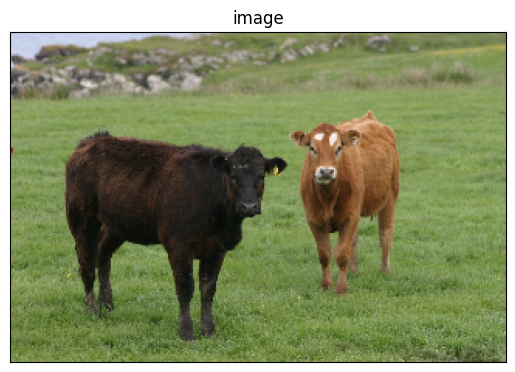

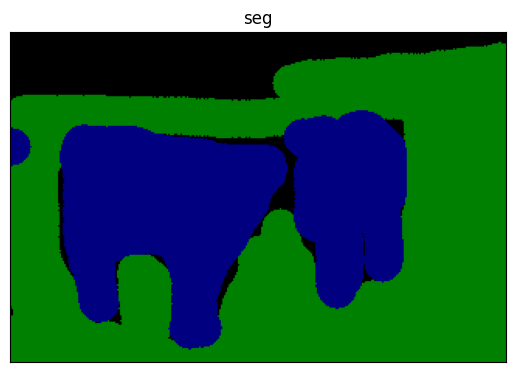

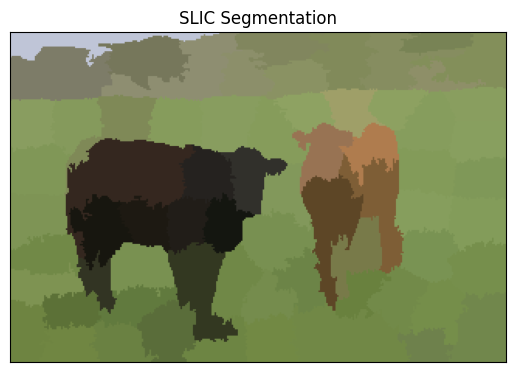

In [34]:
#  plot a sample image and its ground truth segments
image_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s.bmp')
seg_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s_GT.bmp')
plot_image(image_sample, 'image')
plot_image(seg_sample, 'seg')

#  run SLIC on the sample image and plot the corresponding SLIC segments
from skimage.segmentation import slic

segments_sample = slic(image_sample, n_segments=100, compactness=10)
superpixel_plot(image_sample, segments_sample, title = "SLIC Segmentation")

In [35]:
from IPython import embed
import os
current_directory = os.getcwd()
msrc_directory = current_directory + '/MSRC_ObjCategImageDatabase_v1'

#Superpixel dataset preparation

# from Dataset_v1
SEG_LABELS_LIST_v1 = [
    {"id": 9, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 5,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 6, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 7, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 8, "name": "bicycle",    "rgb_values": [192, 0,    128]},
    {"id": 9, "name": "horse",       "rgb_values": [128,   0,    128]},
    {"id": 9, "name": "water",       "rgb_values": [64,   128,    0]},
    {"id": 9, "name": "mountain",       "rgb_values": [64,   0,    0]},
    {"id": 9, "name": "sheep",       "rgb_values": [0,   128,    128]}]

# from Dataset_v2
SEG_LABELS_LIST_v2 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "horse",      "rgb_values": [128, 0,    128]},
    {"id": 5,  "name": "sheep",      "rgb_values": [0,   128,  128]},
    {"id": 6,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 7,  "name": "mountain",   "rgb_values": [64,  0,    0]},
    {"id": 8,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 9,  "name": "water",      "rgb_values": [64,  128,  0]},
    {"id": 10, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 11, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 12, "name": "bicycle",    "rgb_values": [192, 0,    128]},
    {"id": 13, "name": "flower",     "rgb_values": [64,  128,  128]},
    {"id": 14, "name": "sign",       "rgb_values": [192, 128,  128]},
    {"id": 15, "name": "bird",       "rgb_values": [0,   64,   0]},
    {"id": 16, "name": "book",       "rgb_values": [128, 64,   0]},
    {"id": 17, "name": "chair",      "rgb_values": [0,   192,  0]},
    {"id": 18, "name": "road",       "rgb_values": [128, 64,   128]},
    {"id": 19, "name": "cat",        "rgb_values": [0,   192,  128]},
    {"id": 20, "name": "dog",        "rgb_values": [128, 192,  128]},
    {"id": 21, "name": "body",       "rgb_values": [64,  64,   0]},
    {"id": 22, "name": "boat",       "rgb_values": [192, 64,   0]}]

# create a map rgb_2_label, where mapping the ground truth 3-d array segmentation into a single ID label.
rgb_2_label = {}
for i in SEG_LABELS_LIST_v1:
    rgb_2_label[tuple(i['rgb_values'])] = i['id']

### Question 5: Superpixel Dataset (30 points)

First, we dilate each superpixel and save the output superpixel patch from SLIC into 224X224 size image (after rescaling), alongwith the ground truth segments label.

For the purpose of consistency, we adopt the existing SLIC implementation from the scikit-learn machine learning package.

Suggested algorithm: Save the superpixels along with their segmentation class. You could implement this as follows:

For each image
1. Get superpixels sp_i for image x. We adopt 100 segments in this assignment, 'segments = slic(image, n_segments=100, compactness=10)'.
2. For every superpixel sp_i in the image, \\
    2.1. find the smallest rectangle which can enclose sp_i <br>
    2.2. Dilate the rectangle by 3 pixels.<br>
    2.3. Get the same region from the segmentation image (from the file with similar name with *_GT). The class for this sp_i is mode of segmentation classes in that same region. Save the dilated region as npy (jpg is lossy for such small patches).<br>


Alternatively, you could create a single csv with columns segment patch location, class label for each sp_i of each image.<br>italicized text

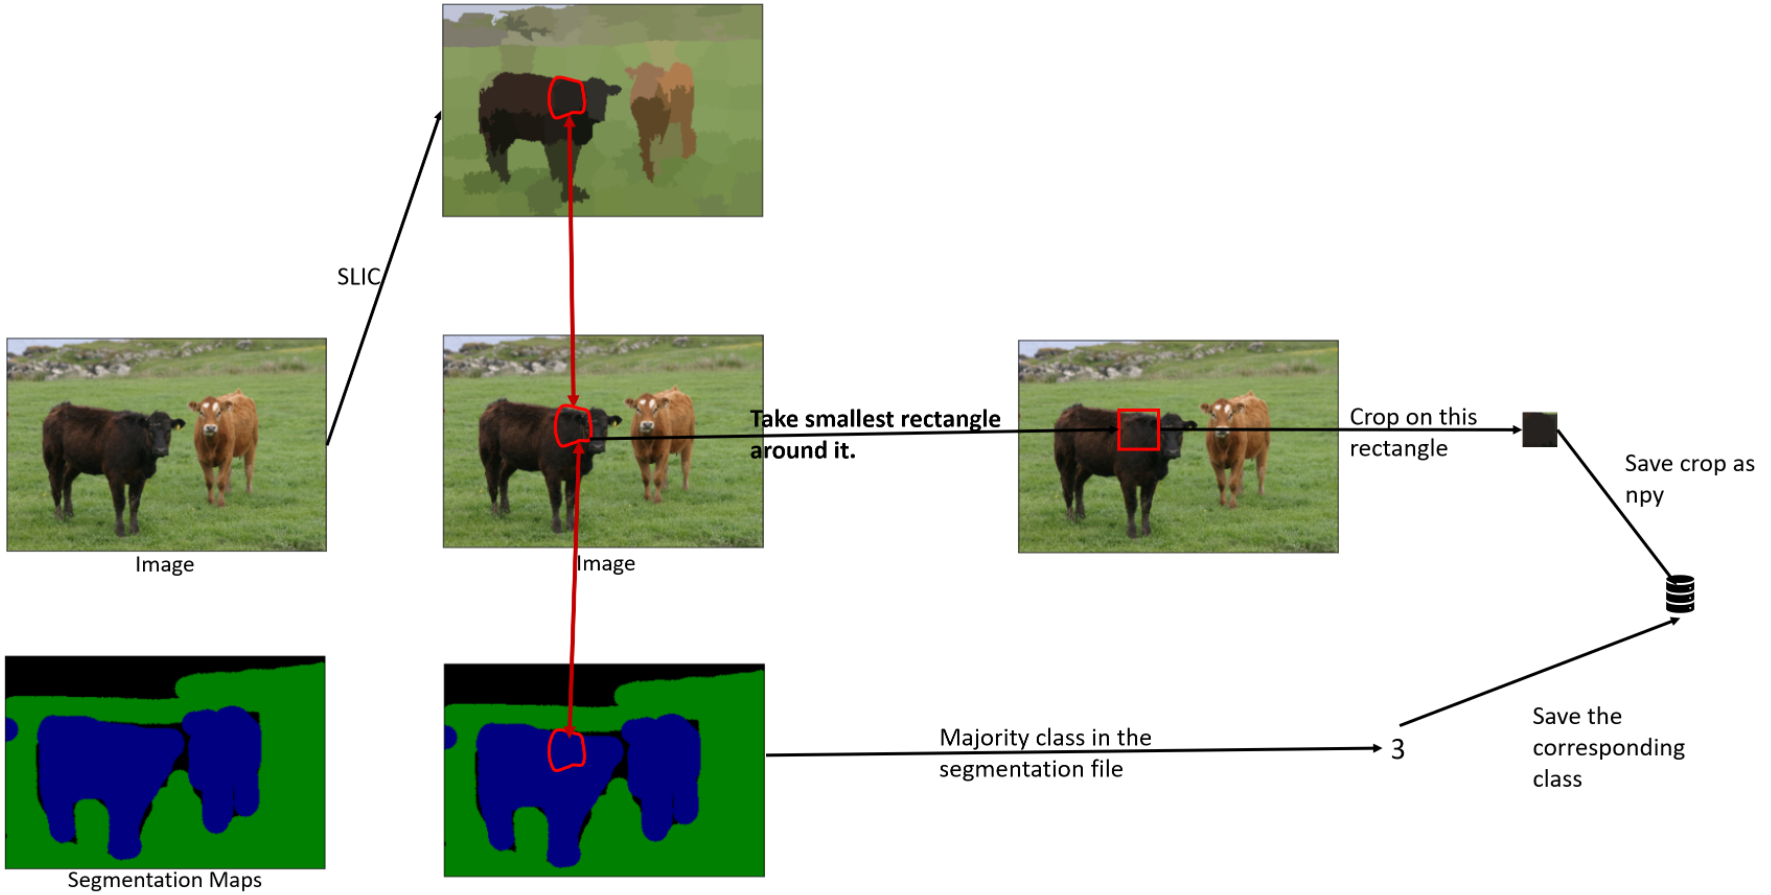


In addition to your code, **the primary graded deliverables** for this question are the 12 demo images we request after you have written code for the dataset.

In [36]:
# run SLIC on each original images and save the (segment patch, ID label) pair
# segments = slic(image, n_segments=100, compactness=10)
# it may take up to half an hour to process, depending on the hardware resources
# save the output file names to train.txt
# Alternatively, you don't save the segment patch and ID label offline, instead,
# you process them on the fly later.

import os
import numpy as np
import torch
import torch.utils.data as data
from PIL import Image
from torchvision import transforms
import _pickle as pickle
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import glob
import pandas as pd
from torch.optim import lr_scheduler
import torch.optim as optim
import time
import copy
from tqdm import tqdm

def get_rect(slic_img, i):
  indices = np.where(slic_img==i)
  if len(indices[0])==0:
    return None

  # rectangular area
  xmin, ymin = min(indices[1]), min(indices[0])
  xmax, ymax = max(indices[1]), max(indices[0])

  # Dilate
  x_min = max(0, xmin - 3)
  y_min = max(0, ymin - 3)
  x_max = min(slic_img.shape[1], xmax+3)
  y_max = min(slic_img.shape[0], ymax+3)

  return x_min, y_min, x_max, y_max

def get_class(gt_rect):
  labels = []

  for i in range(gt_rect.shape[1]):
    for j in range(gt_rect.shape[0]):
      label = rgb_2_label[tuple(gt_rect[j,i])]
      labels.append(label)
  return labels[np.argmax(np.array(labels))]

def read_img(path):
  pass


def crop_img(img,indices):
  cropped_img = img[indices[1]:indices[3], indices[0]:indices[2], : ]
  return cropped_img

# if os.path.exists('./datasets/train.txt'):
#     os.remove('./datasets/train.txt')

# for filename in os.listdir(msrc_directory):
#     # Your code
#     pass

def make_dir(dir):
  path = os.path.join(msrc_directory, dir)
  if not os.path.exists(path):
    os.mkdir(path)
  return path

dataset_dir = 'dataset'
train_dir = 'dataset/train'
test_dir = 'dataset/test'
dataset_path = make_dir(dataset_dir)
train_path = make_dir(train_dir)
test_path = make_dir(test_dir)

os.chdir(msrc_directory)
img_list = sorted(glob.glob("*.bmp"))
train_imgs = img_list[:int(0.8*len(img_list))]
test_imgs = img_list[int(0.8*len(img_list)):]
N_sp = 100

def generate_data_set(img_list, path, csv_path):
  labels_list = []
  patch_list = []
  for img in img_list:
    if '_GT' not in img:
      img_file = img
      gt_img_file = img.replace(".bmp","_GT.bmp")

      sample_img = cv2.imread(os.path.join(msrc_directory, img_file))
      sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
      sample_seg = cv2.imread(os.path.join(msrc_directory, gt_img_file))
      sample_seg = cv2.cvtColor(sample_seg, cv2.COLOR_BGR2RGB)

      slic_img = slic(sample_img, n_segments=N_sp, compactness=10)
      for i in range(N_sp):
        sp_rect = get_rect(slic_img, i)
        if sp_rect is not None:
          image_rect = crop_img(sample_img, sp_rect)
          gt_rect = crop_img(sample_seg, sp_rect)
          gt_class = get_class(gt_rect)
          labels_list.append(gt_class)
          img_rect_path = os.path.join(path, img.replace(".bmp","_Numpy_"+str(i+1)+".npy"))
          patch_list.append(img_rect_path)
          np.save(img_rect_path, image_rect)
  data_dic = {"path":patch_list, "label":labels_list}
  df = pd.DataFrame(data_dic, columns = ["path", "label"])
  df.to_csv(csv_path, index = False, header=True)



In [37]:
generate_data_set(train_imgs, train_path, os.path.join(train_path, "train.csv"))
generate_data_set(test_imgs, test_path, os.path.join(test_path, "test.csv"))

In [38]:
# segments_sample
# indices = np.where(segments_sample==69)
# xmin, ymin = min(indices[1]), min(indices[0])
# xmax, ymax = max(indices[1]), max(indices[0])
# print(xmin, ymin, xmax, ymax)

In [39]:
_

# -------------
# Dataset class
# -------------
#
# ``torch.utils.data.Dataset`` is an abstract class representing a
# dataset.
# Your custom dataset should inherit ``Dataset`` and override the following
# methods:
#
# -  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
# -  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
#    be used to get sp_i sample
#
# Let's create a dataset class for our superpixel dataset. We will
# read the csv in ``__init__`` but leave the reading of images to
# ``__getitem__``. This is memory efficient because all the images are not
# stored in the memory at once but read as required.
#
# Sample of our dataset will be a dict
# ``{'superpixel image': image, 'superpixel class': class}``. Our dataset will take an
# optional argument ``transform`` so that any required processing can be
# applied on the sample. Remember to resize the image using ``transform``.
transform_train = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])


transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


class SegmentationData(data.Dataset):

    def __init__(self, data_path, csv_file, transform=None):
        df = pd.read_csv(os.path.join(data_path, csv_file))
        self.patches = df['path']
        self.labels = df['label']
        self.length = len(self.patches)
        self.transform = transform

    def __len__(self):
        return self.length

    def __getitem__(self, index):
      img_path = self.patches[index]
      img = np.load(img_path, allow_pickle=True)
      label_idx = int(self.labels[index])
      if self.transform:
        img = self.transform(img)
      return img, torch.tensor(label_idx)



Show some outputs! Choose 1 image. For that image, plot the image, along with the superpixel map for the image, as you did for Assignment 1. Then, show the first 10 superpixel patches for the image, retrieved from your dataset.

The output for this portion will be 12 images, displayed below your code below.

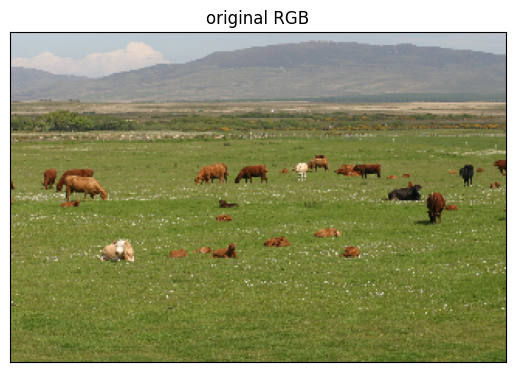

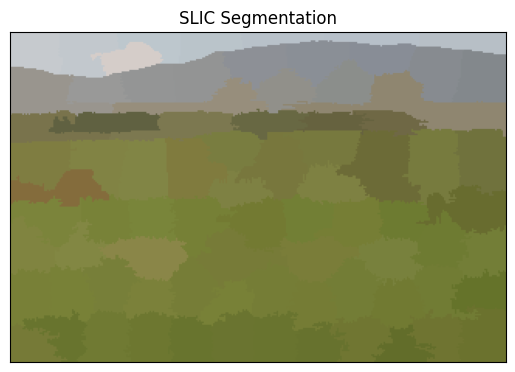

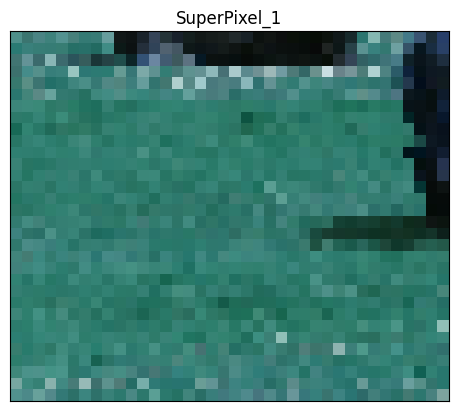

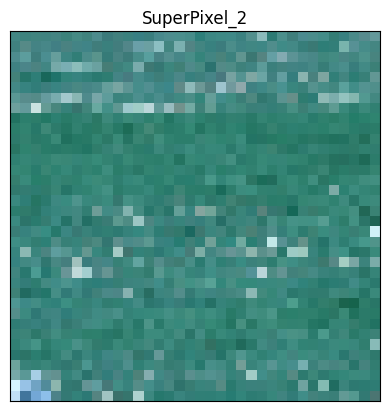

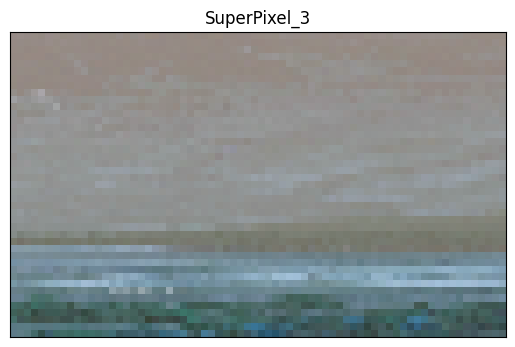

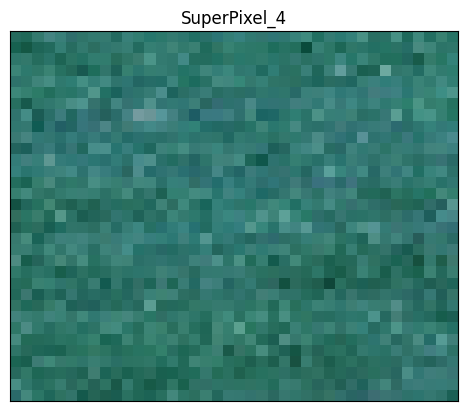

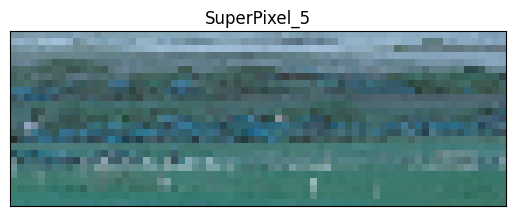

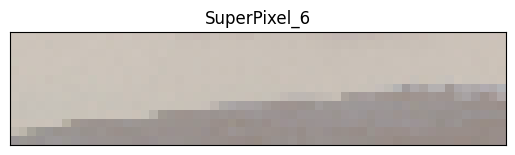

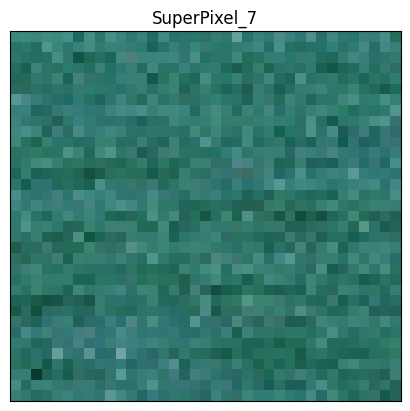

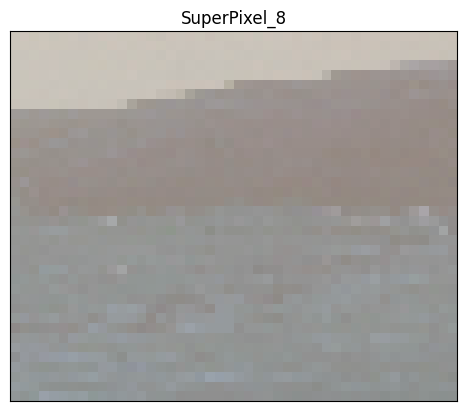

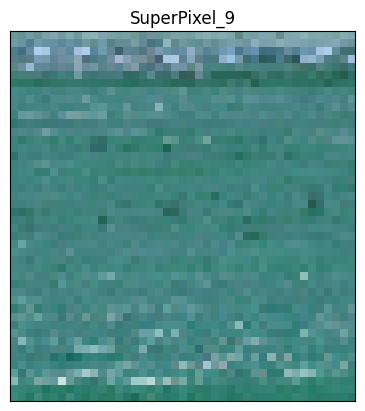

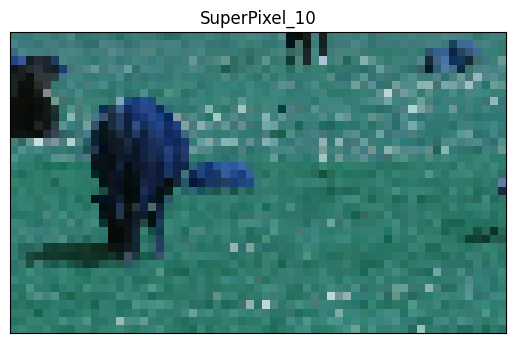

In [40]:
### YOUR CODE TO PLOT 12 images (original RGB + superpixel map + first 10 superpixels) ###
from google.colab.patches import cv2_imshow
img_file = '1_10_s.bmp'
img = cv2.imread(os.path.join(msrc_directory, img_file))
slic_img = slic(img, n_segments = 100, compactness=10)
plot_image(img, 'original RGB')
superpixel_plot(img, slic_img, title = "SLIC Segmentation")
img_no = 0

sample = img_file.replace('.bmp','')
for np_img in glob.glob(msrc_directory+"/**/*.npy", recursive = True):
  if sample in np_img:
    numpy_img = np.load(np_img)
    img_no+=1
    plot_image(numpy_img, 'SuperPixel_'+str(img_no))
    if img_no == 10:
      break

### Question 6: Deep Network (10 points)

You could use a pre-trained network (like VGG) and replace the last few layers with a fully connected layer.

In [41]:
# Model definition
# class SegmentationNN(nn.Module):
#     def __init__(self):
#         # Your code
#         pass


#     def forward(self):
#         # Your code
#         pass
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class UNetClassifier(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNetClassifier, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, num_classes, kernel_size=2, stride=2)
        )

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        self.fc = nn.Linear(num_classes, num_classes)

    def forward(self, x):
        x1 = self.encoder(x)

        x2 = self.decoder(x1)

        x3 = self.global_avg_pool(x2)

        x4 = x3.view(x3.size(0), -1)
        output = self.fc(x4)

        return output


### Question 7: Optimizer (10 points)

Finally, we define the classification loss and optimizer such that we can learn a superpixel classifier from the backproporgation algorithm.

In [42]:
# Optimizer
class Solver(object):
    def __init__(self, model, lr):
        # Your code
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr = lr)

    def train(self, data_loader, epochs = 10):
        # Your code
        begin = time.time()
        updated_model_wts = copy.deepcopy(self.model.state_dict())
        best_accuracy = 0.0

        for epoch in range(epochs):
          print("Epoch {}".format(epoch))
          self.model.train()
          running_loss = 0
          truth_values = 0

          for data in tqdm(data_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            self.optimizer.zero_grad()
            output = model(inputs)
            temp, preds = torch.max(output,1)
            loss = self.criterion(output, labels)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()*inputs.size(0)
            truth_values += torch.sum(preds==labels.data)
          train_loss = running_loss/train_len
          train_acc = truth_values.double()/train_len
          print('Train Loss: {:.3f} Train Accuracy: {:4f}'.format(train_loss, train_acc))

          if train_acc > best_accuracy:
            best_accuracy = train_acc
            updated_model_wts = copy.deepcopy(self.model.state_dict())

        total_time = time.time() - begin
        print("Time take for training: {:.0f}s".format(total_time))
        print("Test accuracy: {:.4f}".format(best_accuracy))


        return self.model

### Question 8: Putting it together (50 points)

Train your network and observe the loss in time.
During the inference stage, combine the SLIC Superpixels' predicted labels to form the whole input image's superpixel segmentation results.
The following 4 items are the primary graded components:

1. You must randomly split the whole dataset into train and test subset (80:20 split is fine).
2. You must show the training loss of the classifier after every epoch
3. You must show the training accuracy and test accuracy of the classifier after training.
4. You must plot as least one visualization showing the test segmentation map vs. ground truth segmentation map.

In [43]:
import torch.utils.data as data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load the data

# data loader

training_data = SegmentationData(os.path.join(msrc_directory,train_dir), "train.csv", transform_train)
testing_data = SegmentationData(os.path.join(msrc_directory,test_dir), "test.csv", transform_test)
training_data_loader = data.DataLoader(dataset=training_data, batch_size=16, shuffle=True, num_workers=2)
testing_data_loader = data.DataLoader(dataset=testing_data, batch_size=16, shuffle=True, num_workers=2)
train_len = len(training_data)
test_len = len(testing_data)


# model
model = UNetClassifier(3,10)
model = model.to(device)

# train the model
solver = Solver(model,0.01)
solver.train(training_data_loader, epochs = 10)
torch.save(model.state_dict(), 'UNET_weights_v1.pt')




Epoch 0


100%|██████████| 755/755 [01:11<00:00, 10.62it/s]


Train Loss: 0.950 Train Accuracy: 0.690957
Epoch 1


100%|██████████| 755/755 [01:10<00:00, 10.67it/s]


Train Loss: 0.855 Train Accuracy: 0.706360
Epoch 2


100%|██████████| 755/755 [01:11<00:00, 10.62it/s]


Train Loss: 0.853 Train Accuracy: 0.702468
Epoch 3


100%|██████████| 755/755 [01:10<00:00, 10.64it/s]


Train Loss: 0.797 Train Accuracy: 0.713481
Epoch 4


100%|██████████| 755/755 [01:10<00:00, 10.65it/s]


Train Loss: 0.808 Train Accuracy: 0.723336
Epoch 5


100%|██████████| 755/755 [01:10<00:00, 10.65it/s]


Train Loss: 0.766 Train Accuracy: 0.745197
Epoch 6


100%|██████████| 755/755 [01:11<00:00, 10.56it/s]


Train Loss: 0.923 Train Accuracy: 0.694766
Epoch 7


100%|██████████| 755/755 [01:12<00:00, 10.37it/s]


Train Loss: 0.737 Train Accuracy: 0.761179
Epoch 8


100%|██████████| 755/755 [01:22<00:00,  9.19it/s]


Train Loss: 0.769 Train Accuracy: 0.752319
Epoch 9


100%|██████████| 755/755 [01:17<00:00,  9.77it/s]

Train Loss: 0.875 Train Accuracy: 0.689715
Time take for training: 730s
Test accuracy: 0.7612


<ipython-input-29-f18edad7b664>:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


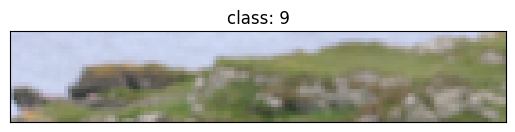

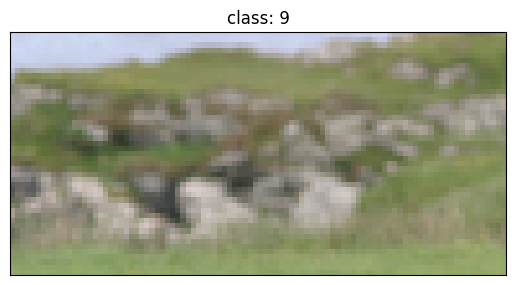

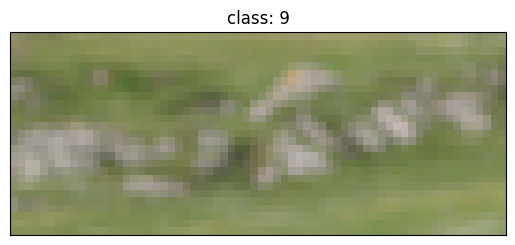

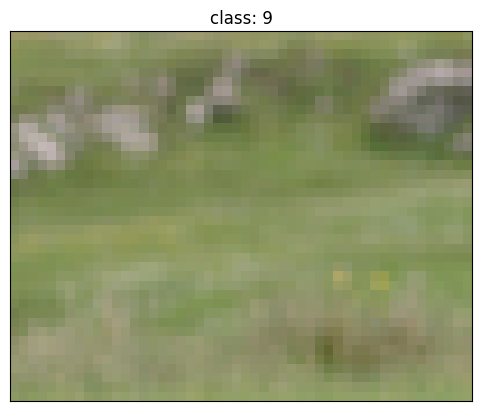

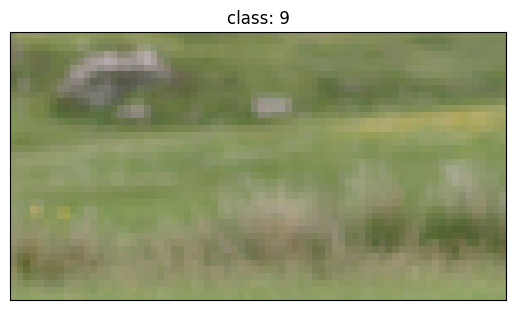

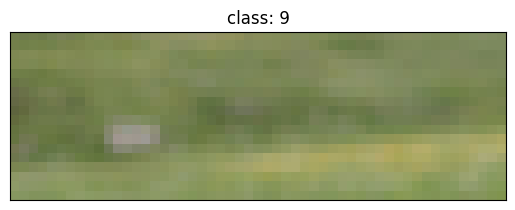

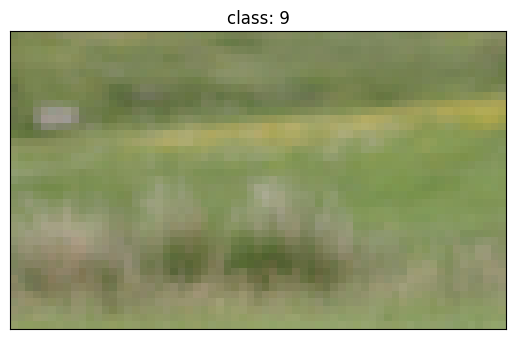

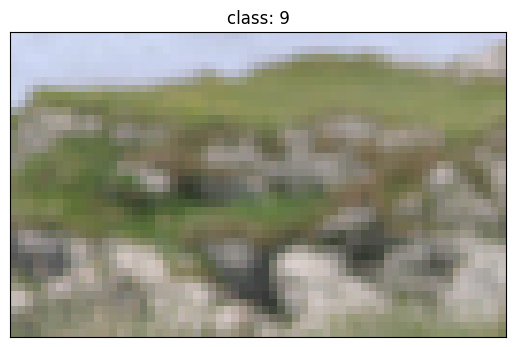

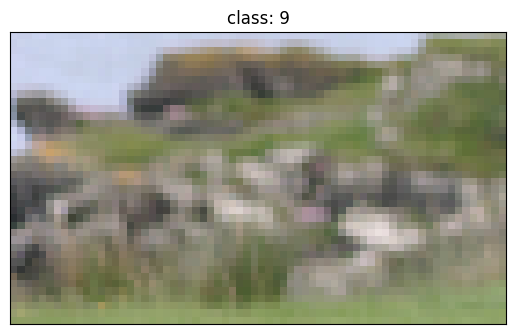

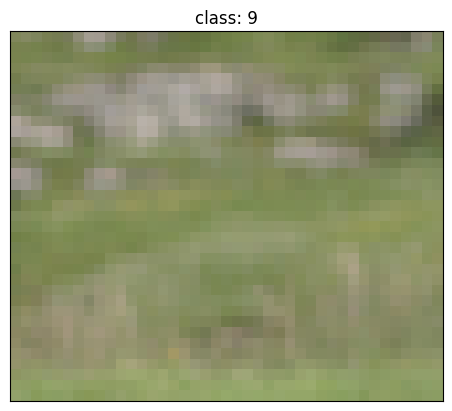

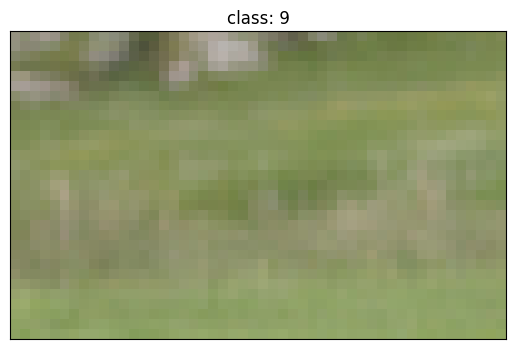

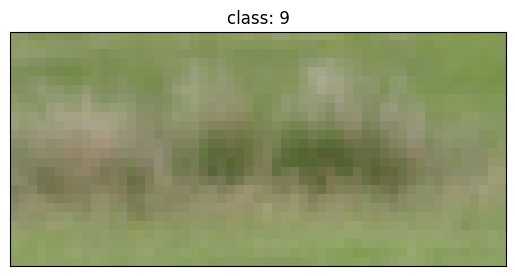

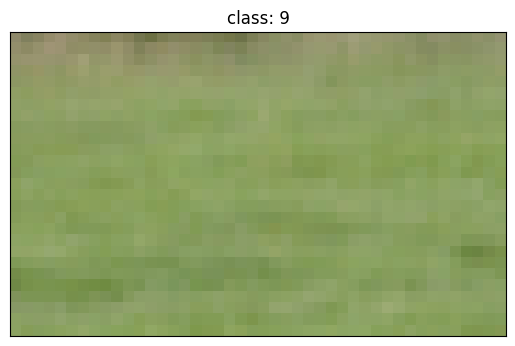

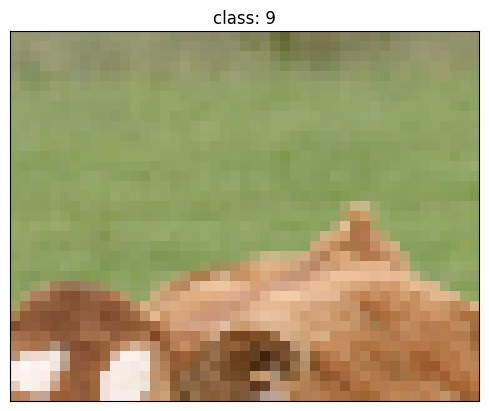

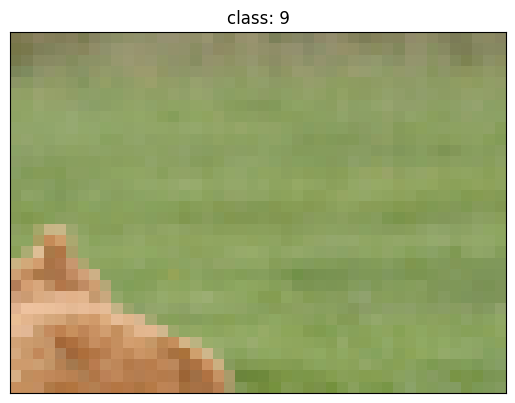

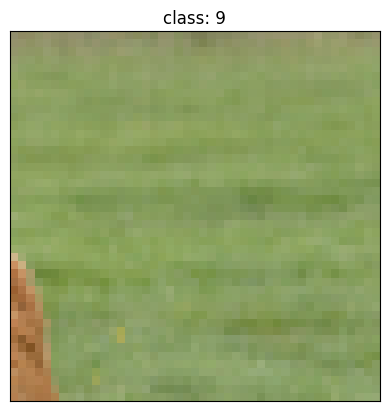

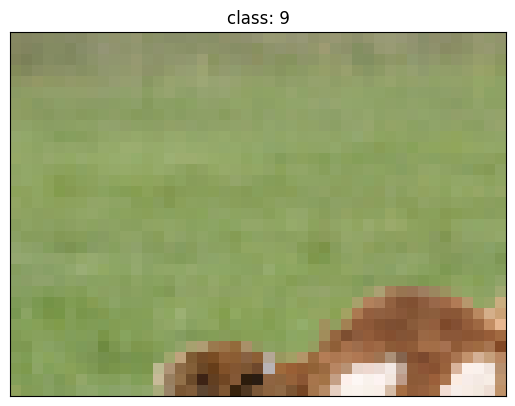

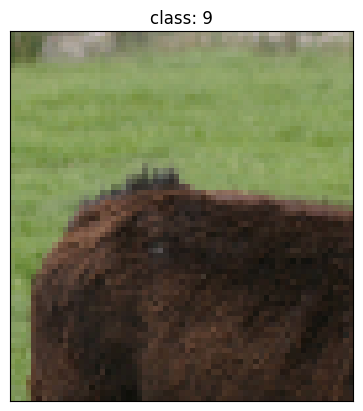

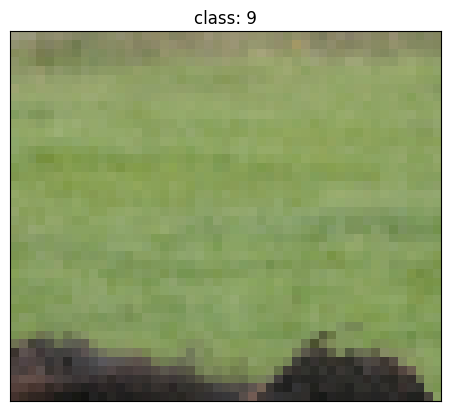

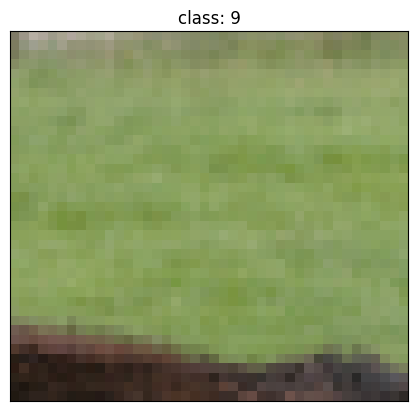

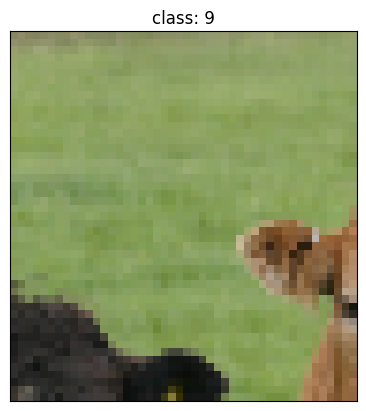

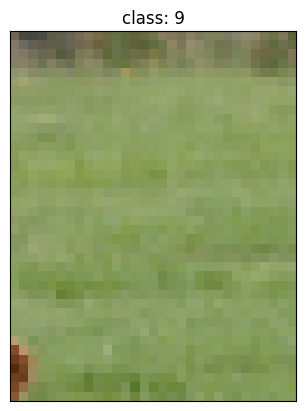

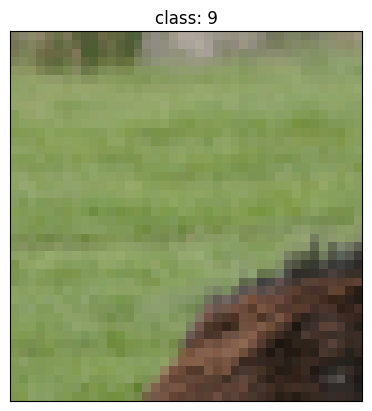

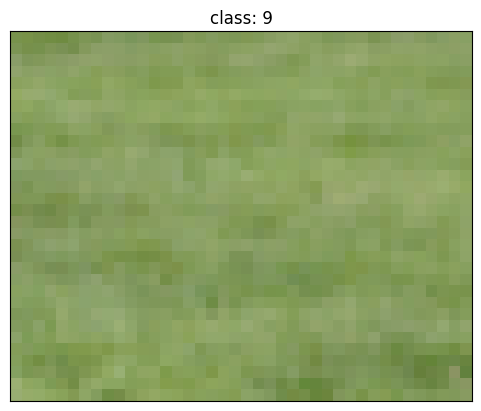

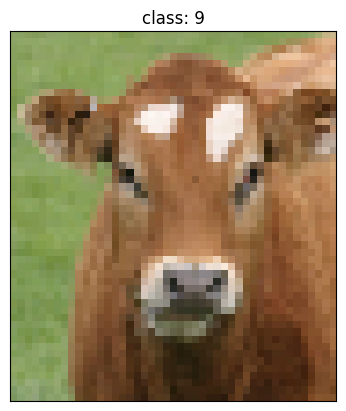

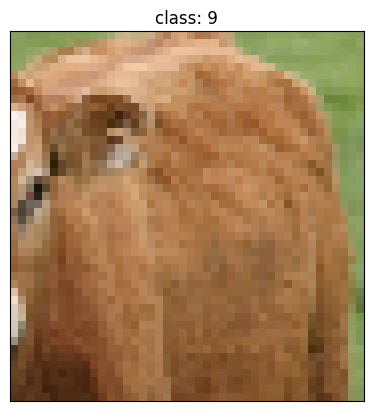

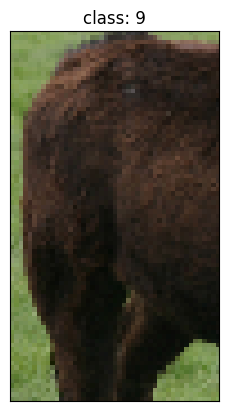

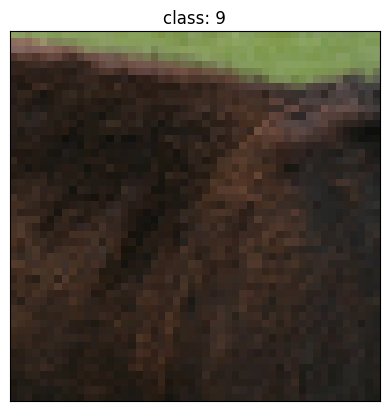

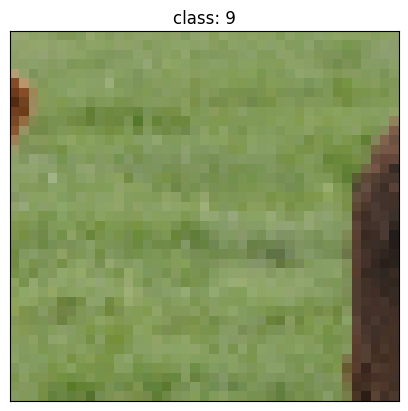

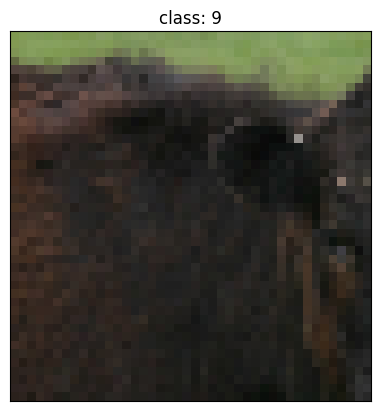

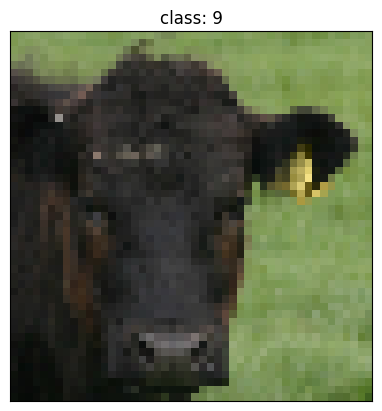

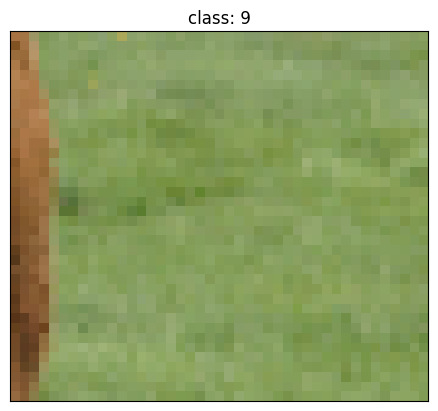

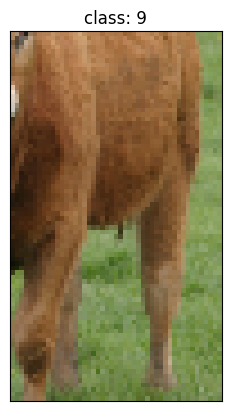

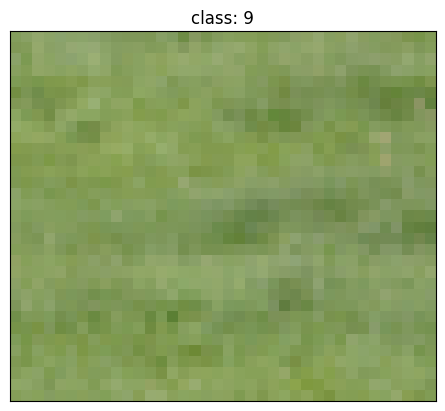

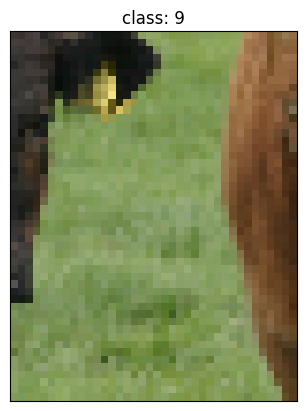

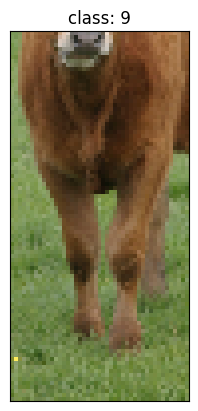

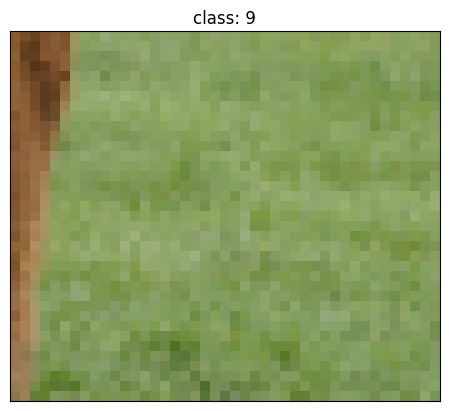

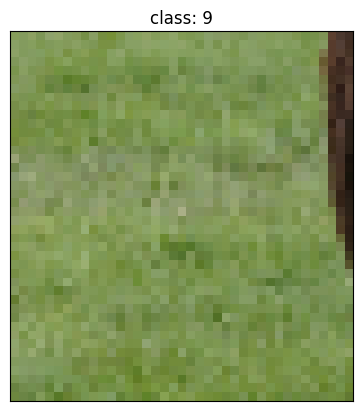

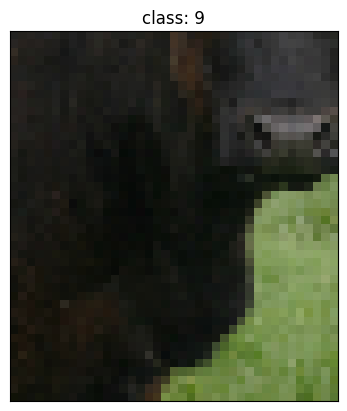

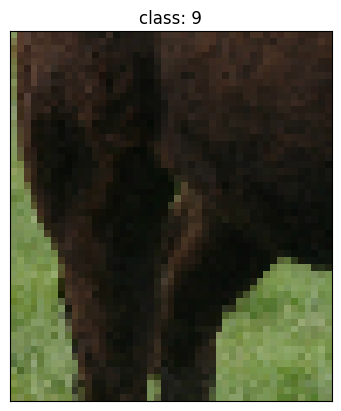

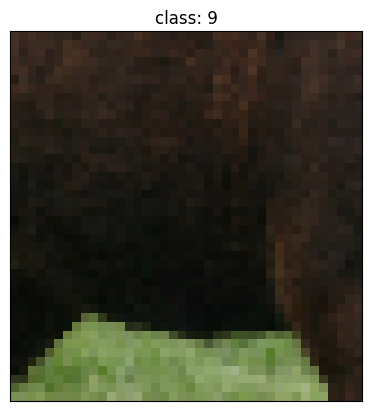

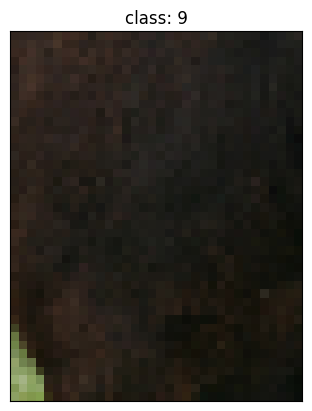

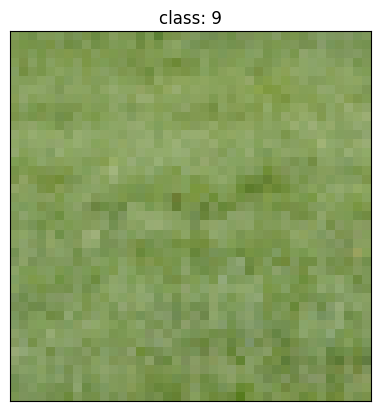

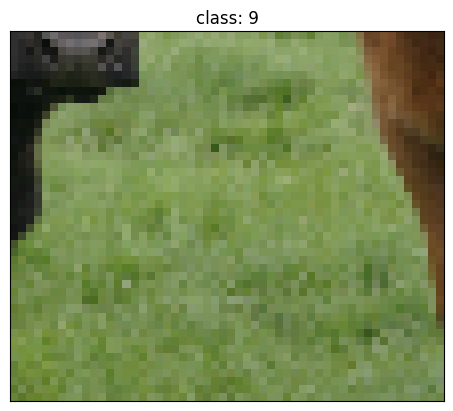

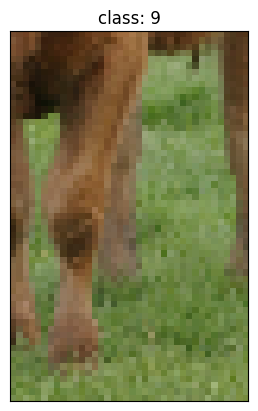

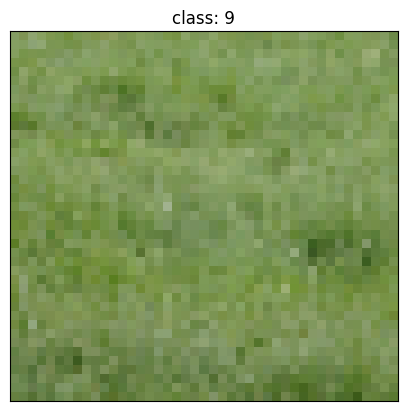

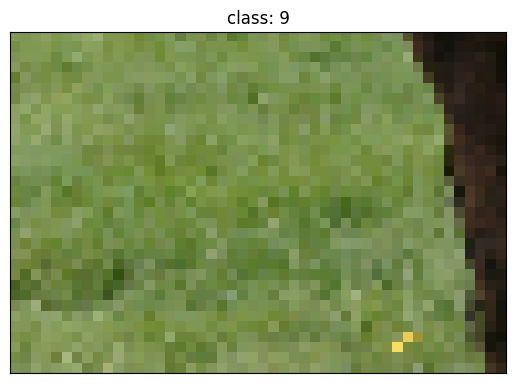

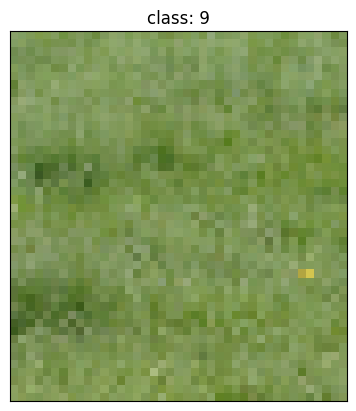

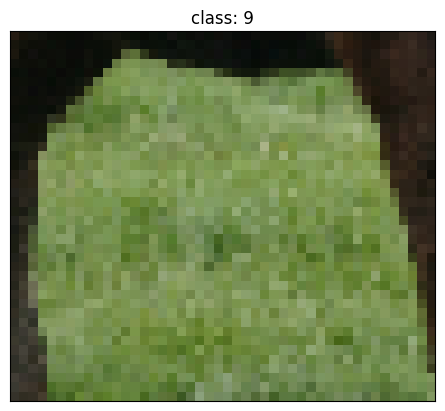

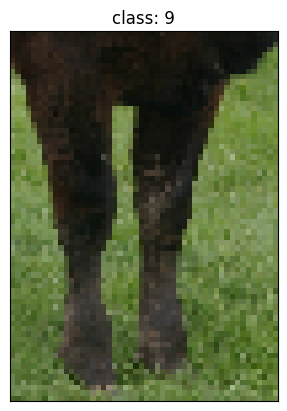

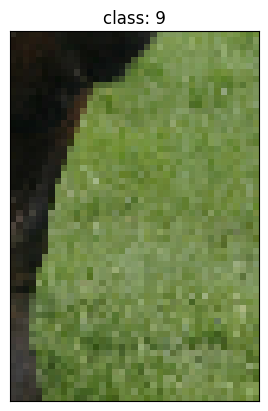

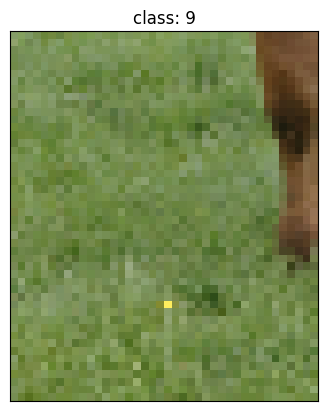

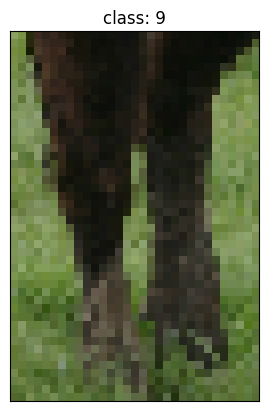

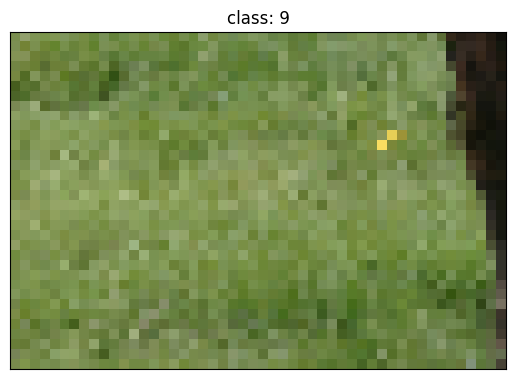

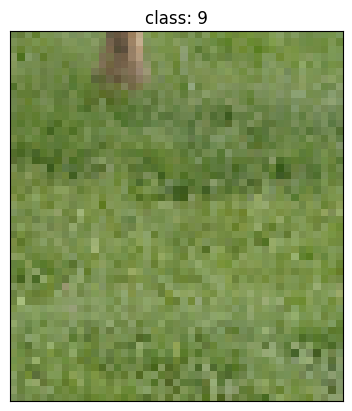

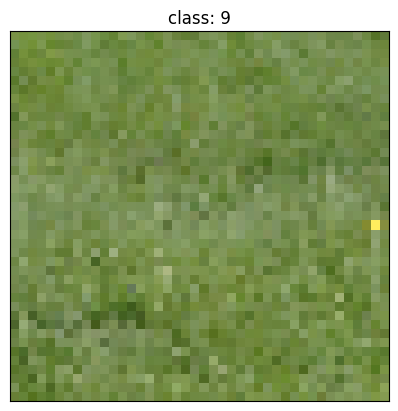

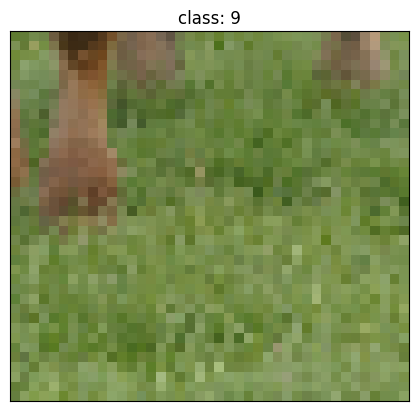

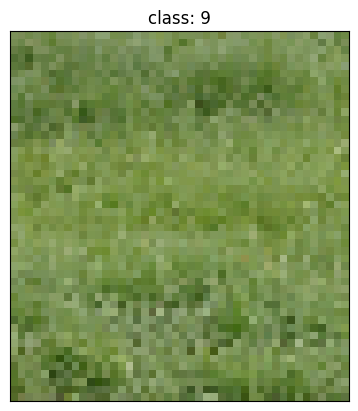

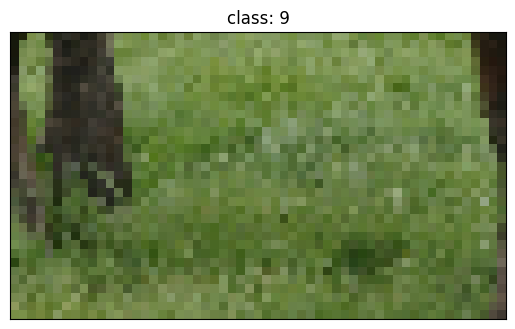

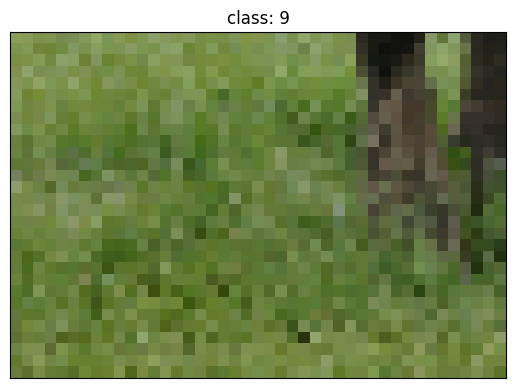

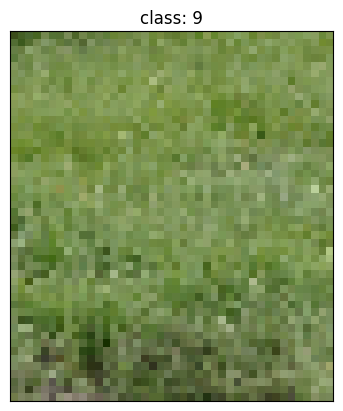

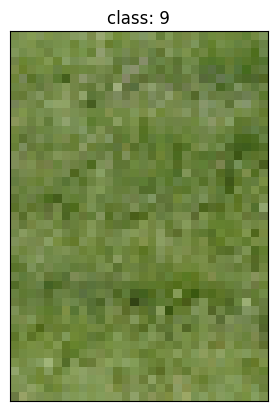

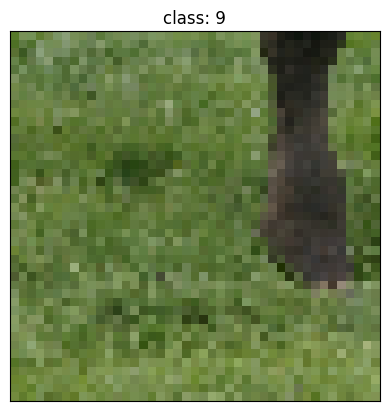

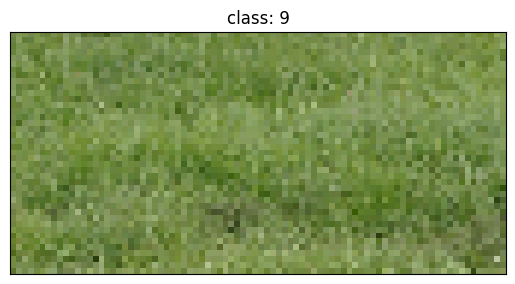

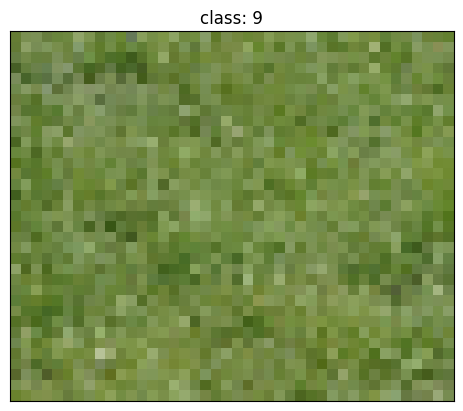

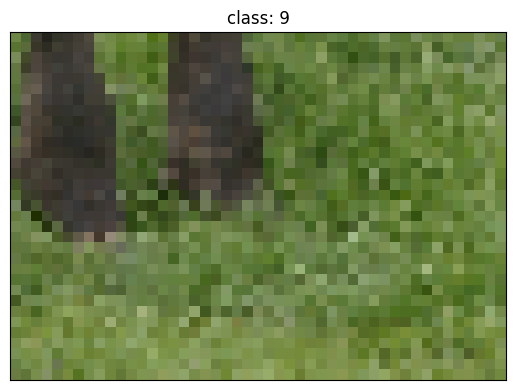

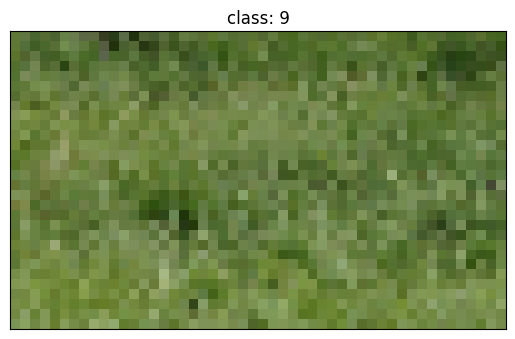

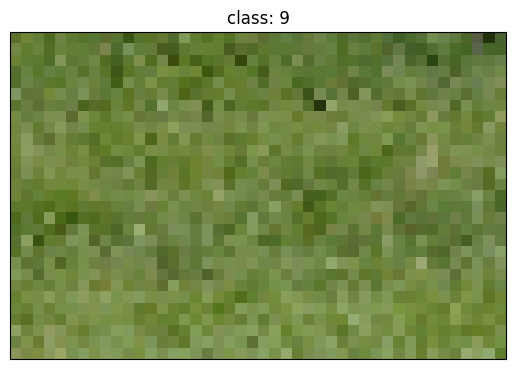

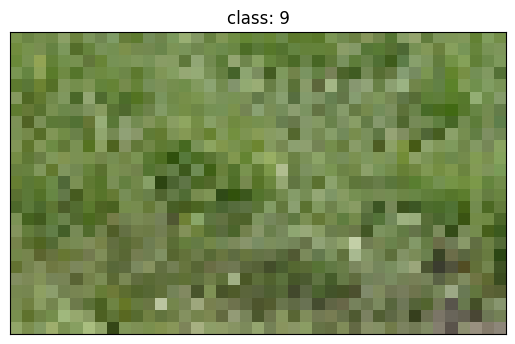

In [47]:
#inference on a sample image
test_file = "1_19_s.bmp"
test_img = cv2.imread(os.path.join(msrc_directory, test_file))
gt_file = test_file.replace(".bmp","_GT.bmp")
gt_img = cv2.imread(os.path.join(msrc_directory, gt_file))

No_sp = 100
slic_img = slic(test_img, n_segments = No_sp, compactness=10)

for i in range(No_sp):
  sp_rect = get_rect(slic_img, i)
  if sp_rect is not None:
    image_rect = crop_img(test_img, sp_rect)
    image_rect1 = transform_test(image_rect).to(device)
    image_rect1 = image_rect1.unsqueeze(0)
    model.eval()
    preds = model(image_rect1)
    temp, preds = torch.max(preds, 1)
    indices = gt_img == i
    plot_image(image_rect, "class: "+str(preds.item()))




### Question 9: Bonus Question (20 points, OPTIONAL):

IMPORTANT: No matter which option you choose, you can earn a maximum of 20 points for this section.

We always want to increase the classifier accuracy and achieve a better performance by building a complicated deep learning model. There are a lot of tricks which are very popular and work in practice. Try to implement either of following two,

1. Could you effictively fuse different deep features from multiple layers in your network? You are welcome to use the pretrained network. Does your network achieve a better accuracy? There are a lot of exploration in the literature, including ION (Inside-Outside Net) [1], Hypercolumns [2], and PixelNet [3]. The following figure illustrates ION architecture combining features from different layers. Can you do similar thing for our Superpixel classifier?

2. Could you build a Multi-resolution network to explore the effectiveness of the multi-scale on the task of Superpixels segmentation? By multi-scale, we mean multiple resolutions of superpixels. See [4] for an example.

[1] Inside-Outside Net: Detecting Objects in Context with Skip Pooling and Recurrent Neural Networks

[2] Hypercolumns for Object Segmentation and Fine-grained Localization

[3] PixelNet: Representationofthe pixels, by the pixels, and for the pixels

[4] Feedforward semantic segmentation with zoom-out features

In [ ]:
# Bonus
